# Header

From **(Durran & Gingrich, 2014)**
> The rapid upscale cascade of small-scale initial error imposes finite limits on the predictability of turbulent flows whose kinetic energy spectrum is proportional to the $-\frac{5}{3}$ power of the norizontal  wavenumber $k$.

> As horizontal wavelengths increase beyond 400km, atmospheric kinetic energy spectrum gradually shifts from a $k^{-\frac{5}{3}}$ to a $k^{-3}$ power law.

$\Rightarrow$ kinetic energy spectrum을 보면 된다.

In [1]:
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

# KE Timeseries

In [2]:
dataset = xr.open_zarr("/geodata2/Gencast/output/2021-06-21.zarr").sel(level=300).squeeze()

u = dataset['u_component_of_wind']
v = dataset['v_component_of_wind']
ke = 0.5 * (u**2 + v**2) # (73, 721, 1440)
ke

<xarray.DataArray (sample: 16, time: 60, lat: 181, lon: 360)> Size: 250MB
dask.array<mul, shape=(16, 60, 181, 360), dtype=float32, chunksize=(4, 15, 46, 90), chunktype=numpy.ndarray>
Coordinates:
    batch    int64 8B 0
    level    int32 4B 300
  * sample   (sample) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * lon      (lon) float32 1kB 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time     (time) timedelta64[ns] 480B 0 days 12:00:00 ... 30 days 00:00:00
  * lat      (lat) float32 724B -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0

In [3]:
# calculate the weighted mean
weights = np.cos(np.deg2rad(ke.lat))
weights.name = "weights"
ke_weighted = ke.weighted(weights)
ke_weighted = ke_weighted.mean(dim=("lat", "lon"))

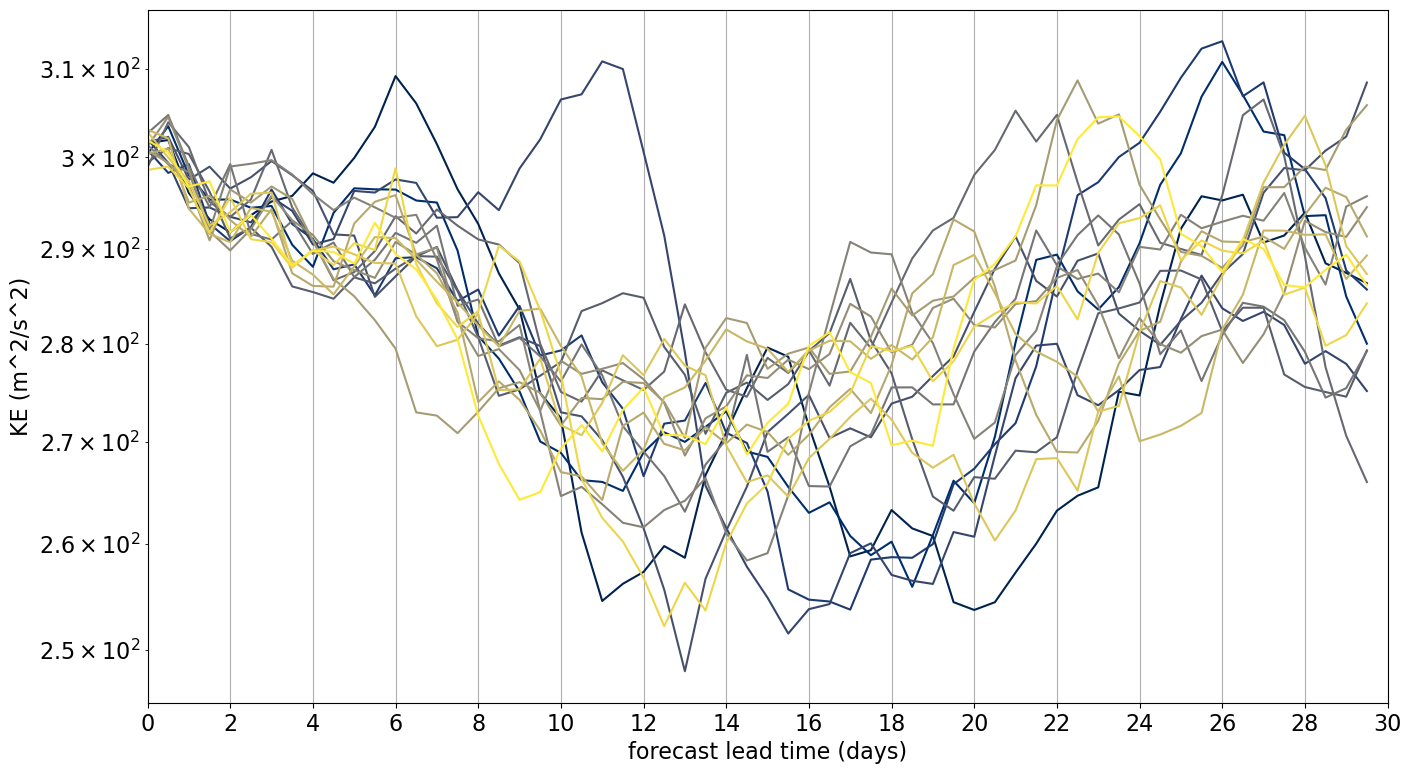

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot ke in log-scale y axis

# increase the figure font size
plt.rcParams.update({'font.size': 16})

colors = plt.cm.cividis(np.linspace(0, 1, 16))
plt.figure(figsize=(16, 9))

# calculate the weighted mean
weights = np.cos(np.deg2rad(ke.lat))
weights.name = "weights"
ke_weighted = ke.weighted(weights)
ke_weighted = ke_weighted.mean(dim=("lat", "lon"))

timesteps = np.arange(0, 60) 
days = timesteps / 2

for ens in range(0, 16):
    plt.plot(days, ke_weighted.isel(sample=ens), color=colors[ens])

plt.yscale("log")

# x axis: 0 ~ 72hr, hourly
plt.xticks(np.arange(0, 31, 2))  # 2일 간격으로 눈금
plt.xlim(0, 30)
plt.xlabel("forecast lead time (days)")
# plt.ylim(10**-6, 30)
plt.ylabel("KE (m^2/s^2)")
plt.grid()
plt.show()
plt.savefig("ke_GenCast.png") 

# KE Spectra

In [46]:
dataset = xr.open_zarr("/geodata2/Gencast/output/2021-06-21.zarr").sel(level=300).squeeze()

ens = "sample"
u = dataset['10m_u_component_of_wind']
v = dataset['10m_v_component_of_wind']

print(u.shape)
print(v.shape)
dataset

(16, 60, 181, 360)
(16, 60, 181, 360)


<xarray.Dataset> Size: 3GB
Dimensions:                   (sample: 16, time: 60, lat: 181, lon: 360)
Coordinates:
    batch                     int64 8B 0
    level                     int32 4B 300
  * sample                    (sample) int64 128B 0 1 2 3 4 5 ... 11 12 13 14 15
  * lon                       (lon) float32 1kB 0.0 1.0 2.0 ... 358.0 359.0
  * time                      (time) timedelta64[ns] 480B 0 days 12:00:00 ......
  * lat                       (lat) float32 724B -90.0 -89.0 -88.0 ... 89.0 90.0
Data variables:
    10m_u_component_of_wind   (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    total_precipitation_12hr  (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    u_component_of_wind       (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>
    geopotential              (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>
    2m_temperature            (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    mean_sea_level_pressure   (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    vertical_velocity         (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>
    temperature               (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>
    specific_humidity         (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>
    sea_surface_temperature   (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    10m_v_component_of_wind   (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 180), meta=np.ndarray>
    v_component_of_wind       (sample, time, lat, lon) float32 250MB dask.array<chunksize=(4, 15, 46, 90), meta=np.ndarray>

In [44]:
n = np.sqrt(u.shape[u.dims.index("lon")])

tilde_u = np.fft.fft(u,axis=u.dims.index("lon"))
tilde_v = np.fft.fft(v,axis=u.dims.index("lon"))

tilde_u = np.abs(tilde_u)**2/n
tilde_u = tilde_u.mean(axis = u.dims.index("sample"))
tilde_v = np.abs(tilde_v)**2/n
tilde_v = tilde_v.mean(axis = u.dims.index("sample"))

tilde_u.shape # (5, 73, 721, 721) = (ens, time, lat, wave)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 60 but corresponding boolean dimension is 360


$$
\tilde{e}(k)= \frac{k}{2}(\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle)
$$

In [ ]:

KE_spectra = 0.5 * (tilde_u + tilde_v)

phi = np.deg2rad(dataset['lat'])
weight = np.cos(phi)

weights = weight / weight.sum()

weights_3d = np.expand_dims(weights, axis=(0, -1))
print(weights_3d.shape)

KE_spectra = KE_spectra * weights_3d
print(KE_spectra.shape)

KE_global = KE_spectra.mean(axis=1)
print(KE_global.shape)

(1, 181, 1)
(60, 181, 360)
(60, 360)


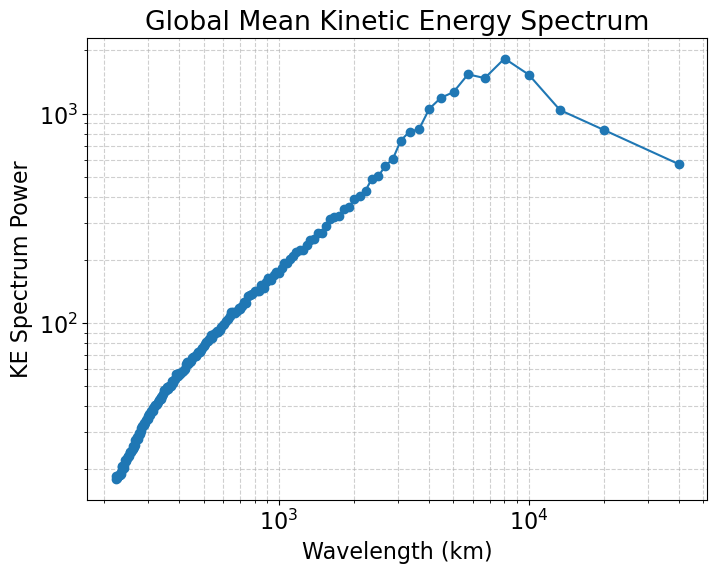

In [47]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# 1. 데이터 불러오기 및 전처리
# ---------------------------
# dataset: sample, time, lat, lon 순서의 4차원 데이터 (예, sample=16, time=60, lat=181, lon=360)
dataset = xr.open_zarr("/geodata2/Gencast/output/2021-06-21.zarr").sel(level=300).squeeze()

# ensemble member 이름이 'sample'이라고 가정
u = dataset['10m_u_component_of_wind']
v = dataset['10m_v_component_of_wind']

# ---------------------------
# 2. FFT를 위한 설정
# ---------------------------
# 경도(lon) 좌표: 단위는 degree. 이를 radian으로 변환
lon = dataset['lon']
# 경도 간격 (radian): 보통 균등격자로 360포인트면 dlon = 2*pi/360
dlon = np.deg2rad(lon.diff('lon').mean().item())  
nlon = u.sizes['lon']

# np.fft.rfftfreq 를 사용하면 '샘플 간격 d'를 고려한 FFT 주파수를 얻습니다.
# dlon가 radian이면 전체 도메인 길이는 nlon*dlon ~ 2*pi (전구면)
freqs = np.fft.rfftfreq(nlon, d=dlon)  # 단위: [cycle/rad]
# 전지구적 동서 방향의 정수형 zonal wavenumber:
k_vals = freqs * 2 * np.pi           # 결과: 0, 1, 2, ... (dimensionless)

# ---------------------------
# 3. 동쪽 방향(경도) FFT 수행
# ---------------------------
# FFT는 각 ensemble, time, lat에 대해 경도축(last axis)에서 수행합니다.
# norm='ortho' 를 사용하면 Parseval의 정리가 성립 (즉, 원래 에너지와 변환된 에너지 합이 일치)
u_fft = np.fft.rfft(u.values, axis=-1, norm='ortho')
v_fft = np.fft.rfft(v.values, axis=-1, norm='ortho')

# ---------------------------
# 4. KE 스펙트럼 계산
# ---------------------------
# 공식:  \tilde{e}(k)= k/2*(|u_fft|^2 + |v_fft|^2)
# FFT 결과의 제곱 절댓값 (각 모드의 파워)를 계산합니다.
# k_vals 는 1D 배열이므로, 브로드캐스팅을 위해 새로운 축을 추가합니다.
# u_fft.shape: (sample, time, lat, n_k)
power = 0.5 * k_vals[np.newaxis, np.newaxis, np.newaxis, :] * (np.abs(u_fft)**2 + np.abs(v_fft)**2)

# ---------------------------
# 5. Global Mean 계산 (ensemble, time, 위도 평균)
# ---------------------------
# 위도는 면적가중(global mean) 계산 시 중요한 역할을 하므로, cosine weighting을 적용합니다.
lat = dataset['lat']
# weights: 위도가 degrees 단위이므로 radian으로 변환 후 cos 적용
weights = xr.DataArray(np.cos(np.deg2rad(lat.values)), dims=['lat'], coords={'lat': lat})

# power를 xarray DataArray로 변환 (차원: sample, time, lat, wavenumber)
power_da = xr.DataArray(
    power, 
    dims=['sample', 'time', 'lat', 'wavenumber'], 
    coords={'sample': u['sample'], 'time': u['time'], 'lat': lat, 'wavenumber': k_vals}
)

# 위도에 대해 cosine weighting을 하여 평균 (면적가중 평균)
power_weighted = (power_da * weights).sum(dim='lat') / weights.sum(dim='lat')
# ensemble과 time에 대해 단순 평균
global_mean_spectrum = power_weighted.mean(dim=['sample', 'time'])

# ---------------------------
# 6. 파장 (wavelength) 계산 및 k=0 모드 제거
# ---------------------------
# 전지구적 파장: λ = (2πR)/k, 여기서 R = 6371 km (지구 반경)
R = 6371.0  # km
k_array = global_mean_spectrum['wavenumber'].values

# k=0 모드는 0으로 나누어지므로, 이를 제외 (보통 k=0은 평균 유동에 해당)
mask = k_array > 0
k_nonzero = k_array[mask]
# wavelength in km
wavelength = 2 * np.pi * R / k_nonzero
# 해당하는 스펙트럼 값
spectrum = global_mean_spectrum.values[mask]

# ---------------------------
# 7. 결과 Plot
# ---------------------------
plt.figure(figsize=(8, 6))
plt.loglog(wavelength, spectrum, marker='o')
plt.xlabel('Wavelength (km)')
plt.ylabel('KE Spectrum Power')
plt.title('Global Mean Kinetic Energy Spectrum')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.show()


In [59]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# 1. 데이터 로드 및 변수 추출
# ----------------------------------------------------
# 데이터셋: ens (5), time (73), lat (721), lon (1440)
dataset = xr.open_dataset('dataset_paper/pangu1000/pangu1000.nc').squeeze()
u = dataset['u']  # (ens, time, lat, lon)
v = dataset['v']

# 좌표 추출
lon = dataset['lon']
lat = dataset['lat']

# ----------------------------------------------------
# 2. FFT를 위한 설정: 경도 방향
# ----------------------------------------------------
# 경도 간격 (degree) -> radian으로 변환
dlon = np.deg2rad(lon.diff('lon').mean().item())
nlon = u.sizes['lon']

# FFT 주파수 (radian 단위 샘플 간격)
freqs = np.fft.rfftfreq(nlon, d=dlon)
# zonal wavenumber: 0,1,2,... (주파수에 2π를 곱해줌)
k_vals = freqs * 2 * np.pi   # shape: (n_k,)

# ----------------------------------------------------
# 3. 각 ensemble member에 대해 경도 방향 FFT 수행
# ----------------------------------------------------
# FFT는 마지막 축(lon 축)을 따라 수행합니다.
# norm='ortho'를 사용하여 에너지 보존(파셀 정리) 조건을 만족시킵니다.
u_fft = np.fft.rfft(u.values, axis=-1, norm='ortho')  # shape: (ens, time, lat, n_k)
v_fft = np.fft.rfft(v.values, axis=-1, norm='ortho')  # shape: (ens, time, lat, n_k)

# ----------------------------------------------------
# 4. Ensemble Spectral DKE 계산
# ----------------------------------------------------
# ensemble member 수
N = u.sizes['ens']

# (i) ensemble 평균의 파워 스펙트럼: <|tilde(u)|^2> 및 <|tilde(v)|^2>
u_power_mean = np.mean(np.abs(u_fft)**2, axis=0)  # shape: (time, lat, n_k)
v_power_mean = np.mean(np.abs(v_fft)**2, axis=0)

# (ii) ensemble 평균의 복소수 진폭의 모듈러스 (그 후 제곱)
u_amp_mean = np.mean(np.abs(u_fft), axis=0)        # shape: (time, lat, n_k)
v_amp_mean = np.mean(np.abs(v_fft), axis=0)
u_amp_mean_sq = u_amp_mean**2
v_amp_mean_sq = v_amp_mean**2

# (iii) Unbiased variance 추정: (N/(N-1))*(<|fft|^2> - <|fft|>^2)
var_u = (N/(N-1)) * (u_power_mean - u_amp_mean_sq)
var_v = (N/(N-1)) * (v_power_mean - v_amp_mean_sq)

# (iv) 스펙트럼 DKE: Δẽ = k (var_u + var_v)
# k_vals는 1D 배열이므로 브로드캐스팅합니다.
delta_e = k_vals[np.newaxis, np.newaxis, :] * (var_u + var_v)  # shape: (time, lat, n_k)

# ----------------------------------------------------
# 5. Global Mean 계산 (시간 및 위도 평균)
# ----------------------------------------------------
# 위도 면적 가중: cos(lat)
weights = np.cos(np.deg2rad(lat.values))  # shape: (lat,)

# xarray DataArray로 변환하여 계산 (차원: time, lat, wavenumber)
delta_e_da = xr.DataArray(delta_e,
                          dims=['time', 'lat', 'wavenumber'],
                          coords={'time': dataset['time'],
                                  'lat': lat,
                                  'wavenumber': k_vals})

# 위도에 대해 코사인 가중 평균
delta_e_weighted = (delta_e_da * weights).sum(dim='lat') / weights.sum()
# 시간에 대해 단순 평균
global_mean_dke = delta_e_weighted[24]

# ----------------------------------------------------
# 6. k=0 모드 제외 및 파장 계산
# ----------------------------------------------------
# k=0 모드는 제외 (파장이 무한대가 되어버림)
mask = global_mean_dke['wavenumber'] > 0
k_nonzero = global_mean_dke['wavenumber'].values[mask]
dke_spectrum = global_mean_dke.values[mask]

# 지구 반경 (km)
R = 6371.0
# 파장: λ = (2πR)/k  [km]
wavelength = 2 * np.pi * R / k_nonzero


/tmp/ipykernel_1123006/4034622449.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10^-3, 10^2)


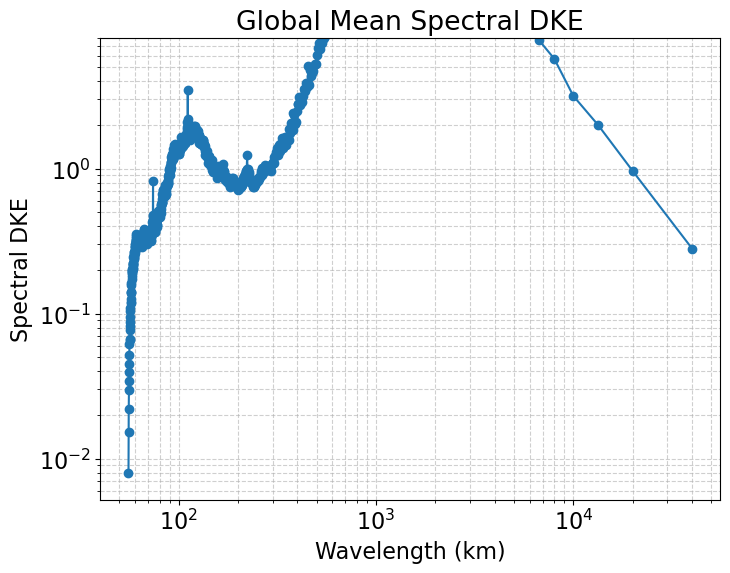

In [61]:

# ----------------------------------------------------
# 7. 결과 Plot: Wavelength vs Spectral DKE
# ----------------------------------------------------
plt.figure(figsize=(8, 6))
plt.loglog(wavelength[:-1], dke_spectrum[:-1], marker='o')
plt.xlabel('Wavelength (km)')
plt.ylim(10^-3, 10^2)
plt.ylabel('Spectral DKE')
plt.title('Global Mean Spectral DKE')
plt.grid(True, which='both', ls='--', alpha=0.6)
plt.show()


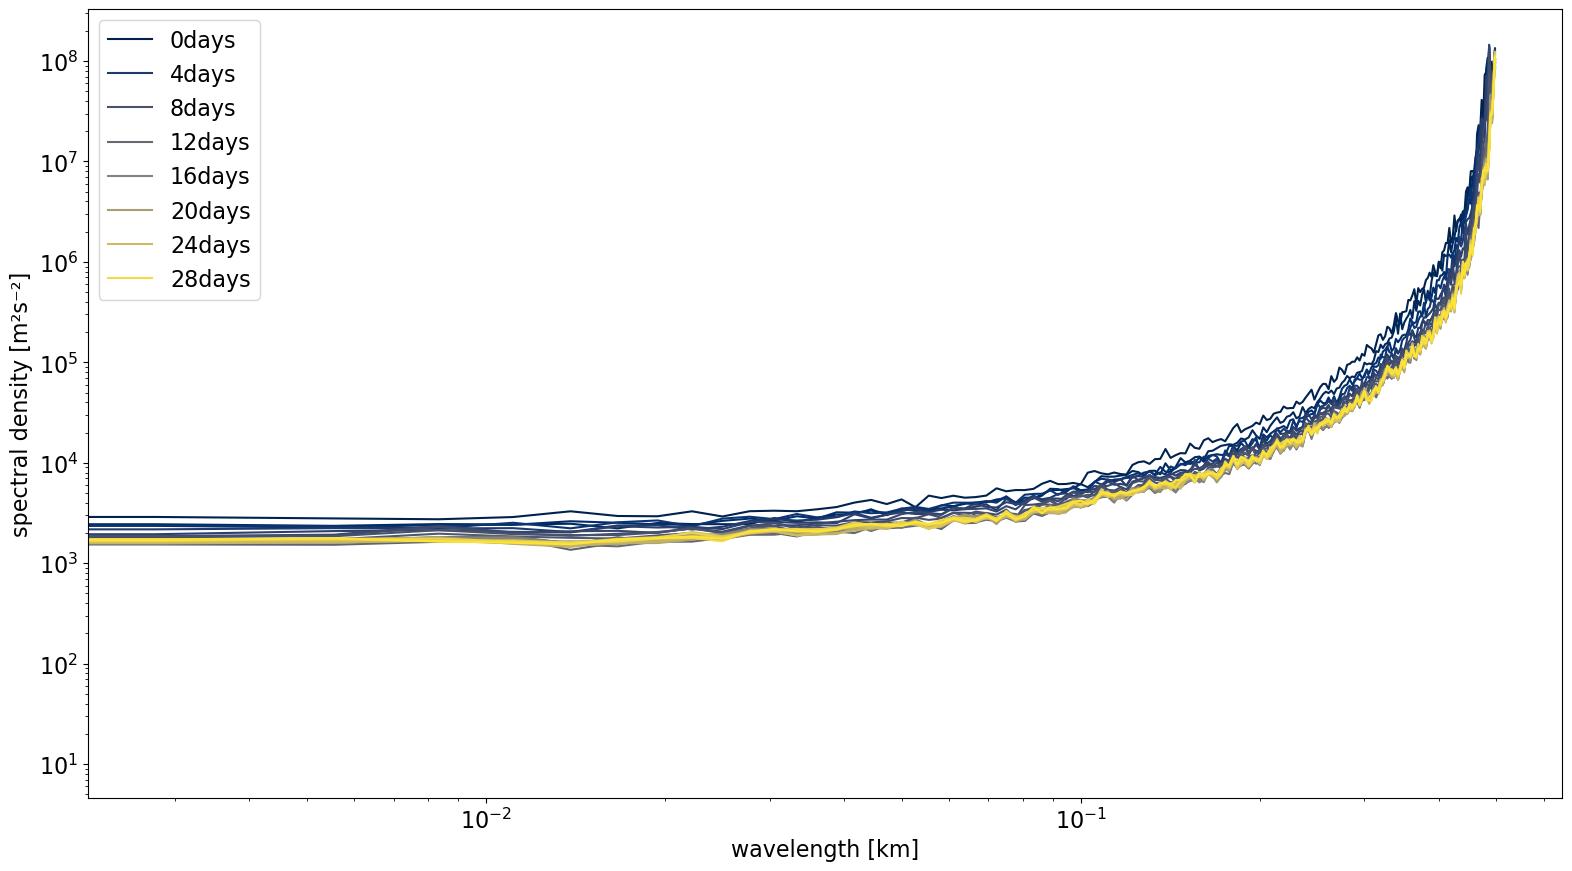

In [ ]:
# plot KE spectra in log-scale y axis

plt.figure(figsize=(16, 9))

colors = plt.cm.cividis(np.linspace(0, 1, 60))

# Calculate wavelength array (assuming spherical harmonics)
n360_circumference = 40075  # Earth's circumference in km
wavenumbers = np.arange(1, u.shape[u.dims.index("lon")]+1)
wavelengths = n360_circumference / wavenumbers  # Convert to wavelengths in km

# Create loglog plot with reversed x-axis
# plt.loglog(10**log_k, DKE_log_defined, 'k-', linewidth=1.5, label='Total KE')

for i in range(0, 60, 2):
   KE_global[i] = KE_global[i]
   if i%8 == 0:
      plt.loglog(k[1:], KE_global[i], color=colors[i], label=f'{int(i/2)}days')
   else:
      plt.loglog(k[1:], KE_global[i], color=colors[i])

# Configure axes
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Set labels with units
plt.xlabel('wavelength [km]')
plt.ylabel('spectral density [m²s⁻²]')
# plt.title('Pangu-100%')

# Set axis limits to match reference plot
# plt.xlim(70, 2.5*10**4)
# plt.gca().invert_xaxis()  # Reverse x-axis direction
# plt.ylim(10**-3, 2*10**2)
plt.legend()
plt.tight_layout()

### DKE Spectra

$$\begin{align}
\Delta\tilde e  &= k(\text{var}(\tilde u) + \text{var}(\tilde v) )\\
&= k\frac{N}{N-1}(\underbrace{\langle \lvert \tilde u_i\rvert^2\rangle + \langle \lvert \tilde v_i\rvert^2\rangle}_{\text{ensemble mean of the KE spectral densities}} - \underbrace{(\langle \lvert \tilde u_i\rvert\rangle^2 + \langle \lvert \tilde v_i\rvert\rangle^2)}_{\text{KE spectral density of the ensemble mean}})
\end{align}$$

In [37]:
var_tilde_u = tilde_u.var(axis=u.dims.index(ens), ddof=1)
var_tilde_v = tilde_v.var(axis=v.dims.index(ens), ddof=1)

DKE_spectra_1 = var_tilde_u + var_tilde_v

var_tilde_u.shape

(60, 181, 360)

In [38]:
u_2_mean = ((tilde_u * np.conj(tilde_u))).mean(axis=u.dims.index(ens))
v_2_mean = ((tilde_v * np.conj(tilde_v))).mean(axis=v.dims.index(ens))

u_mean_2 = tilde_u.mean(axis=u.dims.index(ens)) * np.conj(tilde_u.mean(axis=u.dims.index(ens)))
v_mean_2 = tilde_v.mean(axis=v.dims.index(ens)) * np.conj(tilde_v.mean(axis=u.dims.index(ens)))

N = u.shape[u.dims.index(ens)]
bias = N/(N-1)

DKE_spectra_2 = bias * (u_2_mean + v_2_mean - u_mean_2 - v_mean_2)
DKE_spectra_2.shape

(60, 181, 360)

In [39]:
# weight by cos(lat)

spectra = DKE_spectra_2
print(spectra.shape)
phi = np.deg2rad(dataset['lat'])
weight = np.cos(phi)

k = ((np.arange(spectra.shape[2])+1) * 2 * np.pi * 6317)/spectra.shape[2]
map = np.outer(weight, k)

# print(map.shape)
# spectra = spectra * map
# k = np.arange(spectra.shape[2]) + 1
# print(k)
# spectra = spectra * np.flip(k)

weights = weight / weight.sum()

weights_3d = np.expand_dims(weights, axis=(0 ,-1))
print(weights_3d.shape)

spectra = spectra * weights_3d
print(spectra.shape)

DKE_global = spectra.mean(axis=1)

DKE_global.shape

(60, 181, 360)
(1, 181, 1)
(60, 181, 360)


(60, 360)

### Plot

/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/hiskim1/.conda/envs/hiskim1_gencast/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


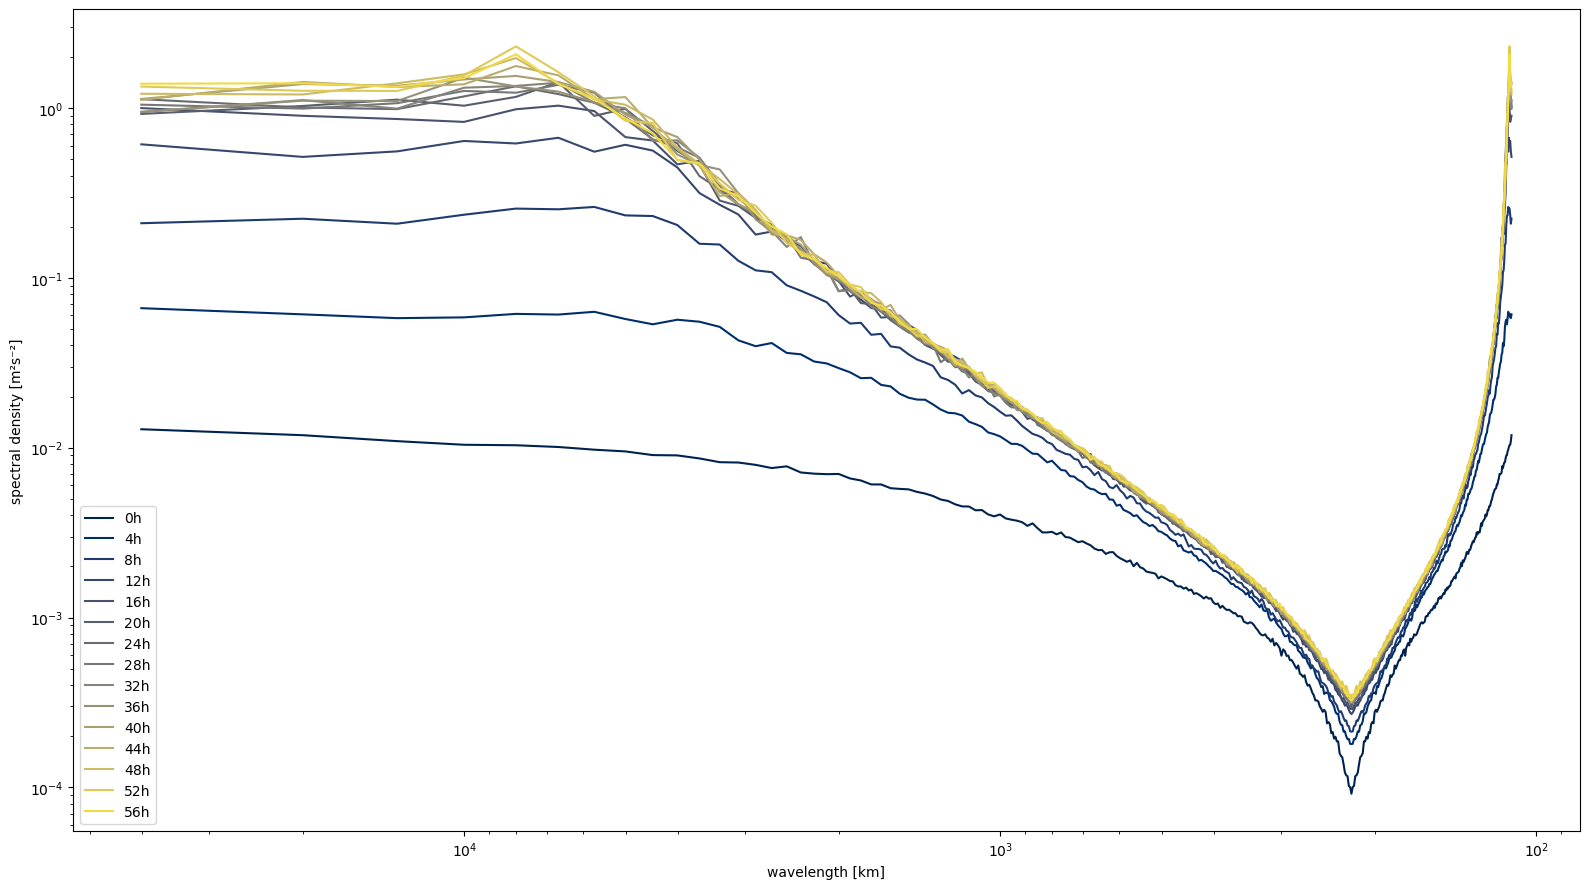

In [40]:

import matplotlib.pyplot as plt
colors = plt.cm.cividis(np.linspace(0, 1, 60))

data = DKE_global[0]*0.5

# Initialize figure with research-quality specifications
plt.figure(figsize=(16, 9))

# Calculate wavelength array (assuming spherical harmonics)
n360_circumference = 40075  # Earth's circumference in km
wavenumbers = np.arange(1, len(DKE_global[0])+1)
wavelengths = n360_circumference / wavenumbers  # Convert to wavelengths in km

# Create loglog plot with reversed x-axis
# plt.loglog(10**log_k, DKE_log_defined, 'k-', linewidth=1.5, label='Total KE')

for i in range(0, 60, 4):
    data = DKE_global[i]*0.5
    plt.loglog(wavelengths, 
               data, 
               color=colors[i], 
               # label=f'{(i+1)*12}h',
               label=f"{i}h"
               )

# Configure axes
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Set labels with units
plt.xlabel('wavelength [km]')
plt.ylabel('spectral density [m²s⁻²]')
# plt.title('Pangu-100%')

# Set axis limits to match reference plot
# plt.xlim(70, 2.5*10**4)
plt.gca().invert_xaxis()  # Reverse x-axis direction
# plt.ylim(10**-3, 2*10**2)
plt.legend()
plt.tight_layout()
# plt.savefig("dke_iconlr1000.png")